## Постановка задачи

Необходимо разработать демонстрационную версию поиска изображений по текстовому запросу.<br>
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. 

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. 

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно несколько описаний.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
#!pip install keras -q

In [2]:
#!pip install tensorflow -q

In [3]:
#!pip install nltk -q

In [4]:
#!pip install spacy -q

In [5]:
#!pip install transformers catboost optuna keras-tuner

In [6]:
#!pip install lightgbm

## Загрузка данных

In [7]:

import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import os

from tqdm.notebook import tqdm
from tqdm import notebook

import spacy
import spacy.cli
import nltk
import transformers
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import keras_tuner


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_validate, cross_val_score


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import optuna


import pickle


In [8]:
path = 'to_upload//'
IMG_SHAPE = (224, 224, 3)
N_FOLDS=3
SEED = 43

In [9]:
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
#os.environ['PYTHONHASHSEED']=str(SEED)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(SEED)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(SEED)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [10]:
# загрузка описания для тренировочных данных 
train_data = pd.read_csv(path+'train_dataset.csv', sep=',')

# загрузка описания для тестовых данных 
test_data = pd.read_csv(path+'test_queries.csv', sep='|', index_col=[0])


In [11]:
train_data.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [12]:
tr1=pd.DataFrame()

In [13]:
test_data.head()

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

- 1 - Имя файла изображения.
- 2 - Идентификатор описания.
- 3 - Доля людей, подтвердивших, что описание соответствует изображению.
- 4 - Количество человек, подтвердивших, что описание соответствует изображению.
- 5 - Количество человек, подтвердивших, что описание не соответствует изображению.

In [14]:
# Загрузка данных с Crowd оценки 
col_names = ['file_name','id_comment', 'per_agree', 'number_agree', 'number_not_agree' ]

crowd_train = pd.read_csv(path+'CrowdAnnotations.tsv', sep='\t', header=None, names=col_names)

In [15]:
crowd_train.head()

file_name                   id_comment  per_agree  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   number_agree  number_not_agree  
0             3                 0  
1             0                 3  
2             0                 3  
3             0                 3  
4             0                 3

In [16]:
crowd_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_name         47830 non-null  object 
 1   id_comment        47830 non-null  object 
 2   per_agree         47830 non-null  float64
 3   number_agree      47830 non-null  int64  
 4   number_not_agree  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


1- Имя файла изображения.
2- Идентификатор описания.
3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где: 
* 1 — изображение и запрос совершенно не соответствуют друг другу 
* 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует 
* 3 — запрос и текст соответствуют с точностью до некоторых деталей 
* 4 — запрос и текст соответствуют полностью.

In [17]:
# Загрузка данных экспертной оценки 
col_names = ['file_name','id_comment','exp1', 'exp2', 'exp3']

expert_train = pd.read_csv(path+'expertAnnotations.tsv', sep='\t', header=None, names=col_names)

In [18]:
expert_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   5822 non-null   object
 1   id_comment  5822 non-null   object
 2   exp1        5822 non-null   int64 
 3   exp2        5822 non-null   int64 
 4   exp3        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [19]:
# посчитаем количество уникальных комментариев
len(list(expert_train['id_comment'].unique()))

977

In [20]:
expert_train.head()

file_name                   id_comment  exp1  exp2  exp3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1     1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1     2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1     2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     1     2     2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     1     1     2

In [21]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = datagen.flow_from_dataframe(
        dataframe=train_data[['image','query_text']].sample(100, random_state=SEED),
        directory=path + '/train_images',
        x_col='image',
        y_col='query_text',
        target_size=(320, 320),
        batch_size=10,
        class_mode='raw',
        subset=None,
        shuffle=True,
        seed=SEED)

test_gen_flow = datagen.flow_from_dataframe(
        dataframe=test_data[['image','query_text']].sample(100, random_state=SEED),
        directory=path + '/test_images',
        x_col='image',
        y_col='query_text',
        target_size=(320, 320),
        batch_size=10,
        class_mode='raw',
        subset=None,
        shuffle=True,
        seed=SEED)

Found 100 validated image filenames.
Found 100 validated image filenames.


In [22]:
def img_randprint(generator, img_rows, img_columns, fig_title, btch_space=1, btch_size=1): 
    
    '''btch_space может быть (generator.samples//btch_size +1)'''
    
    fig, ax = plt.subplots(img_rows, img_columns, figsize=(img_columns*8, img_rows*3))
    for i in range(img_rows*img_columns):
        batch_num = np.random.randint(btch_space)    
        img_num = np.random.randint(btch_size)
        generator.reset()
        for _ in range(batch_num):
            fch, target = next(generator)
        ax[i//img_columns][i%img_columns].imshow(fch[img_num])
        ax[i//img_columns][i%img_columns].set_title(str(target[img_num]), fontsize=12)
        ax[i//img_columns][i%img_columns].axis ('off')
    fig.suptitle(fig_title, y=0.95, fontsize=18)
    plt.show()

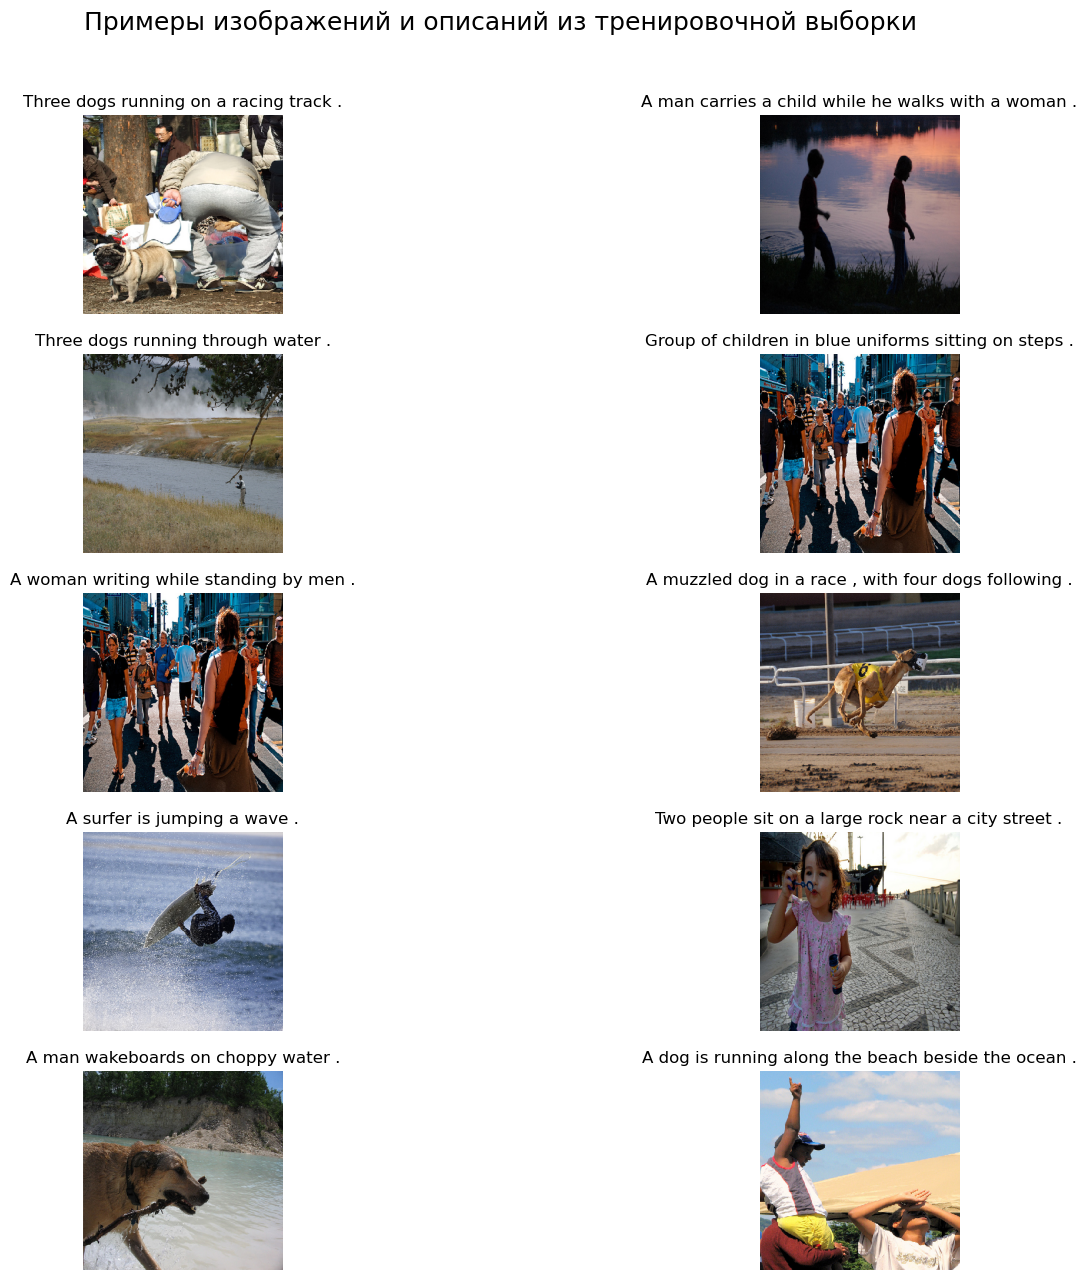

In [23]:
img_randprint(train_gen_flow,
              5, 2,
              'Примеры изображений и описаний из тренировочной выборки',
              train_gen_flow.samples//10,
              10)

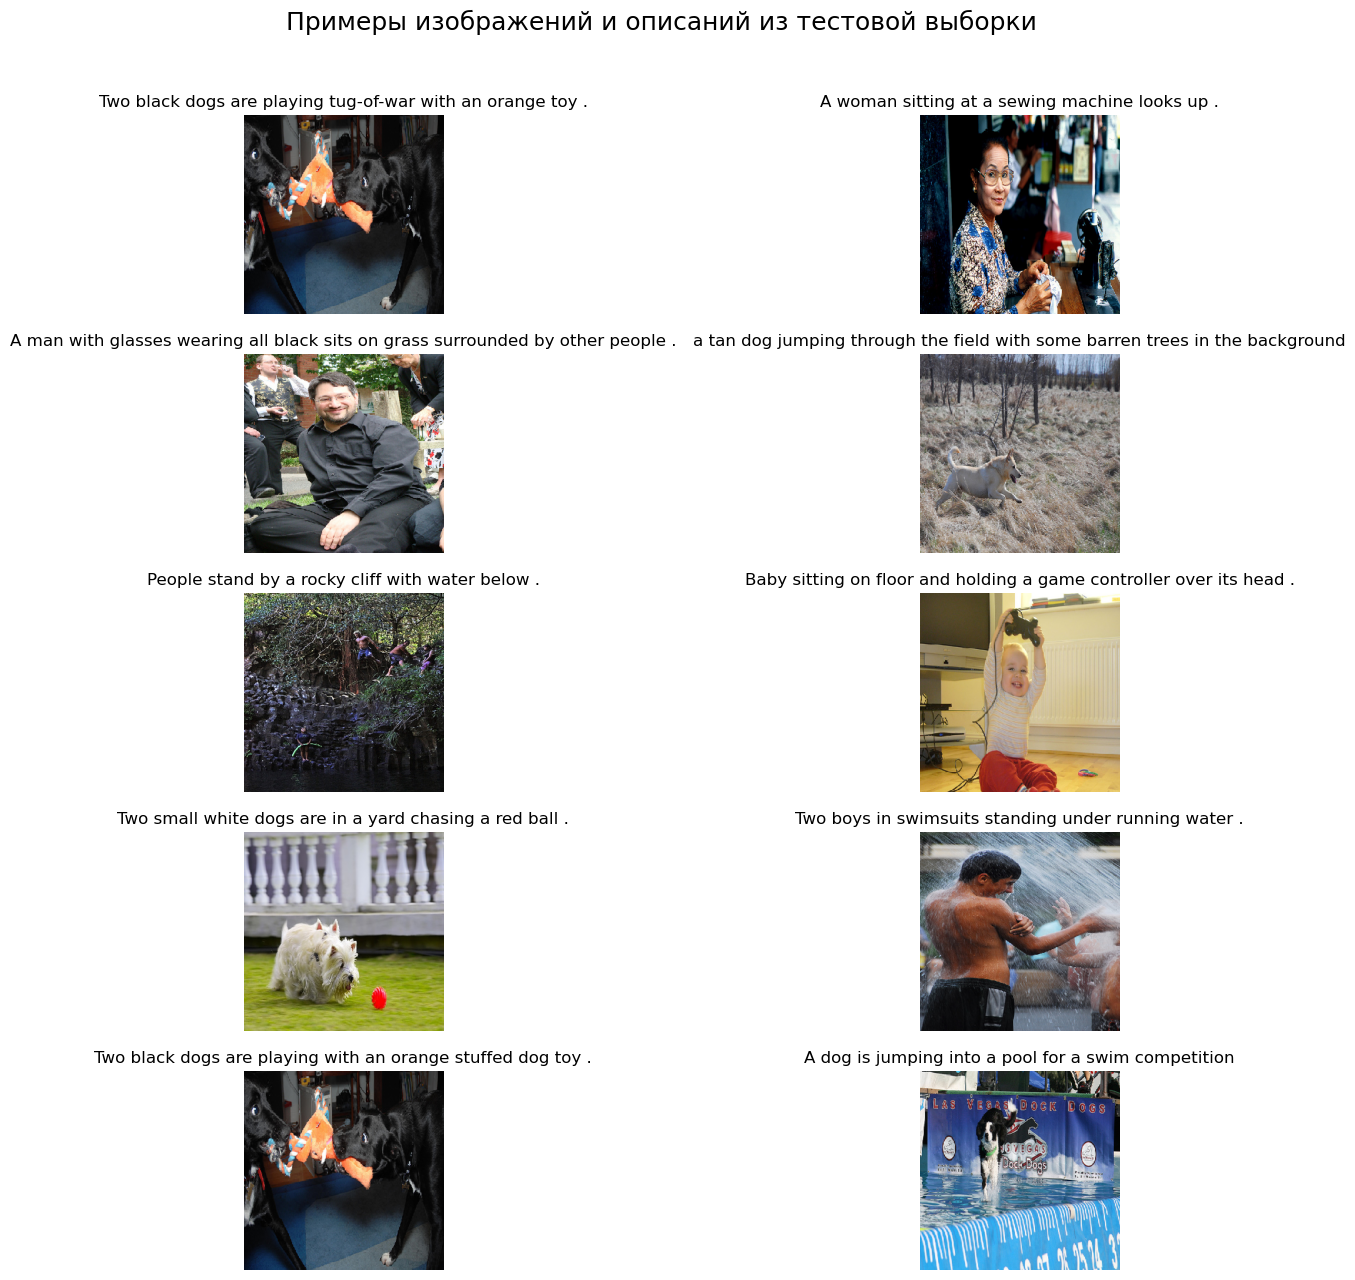

In [24]:
img_randprint(test_gen_flow,
              5, 2,
              'Примеры изображений и описаний из тестовой выборки',
              test_gen_flow.samples//10, 10)

In [25]:
del test_gen_flow, train_gen_flow

**Выводы:** 
 1. Данные в обучающей выборке имеют большое количество описаний которые не соответсвуют изображениям
 2. Описание для тестовых изображений более точные 

## Анализ данных

In [26]:
# проверим уникальные сочетания комментариев 
exp_scores = list(zip(expert_train['exp1'], expert_train['exp2'], expert_train['exp3']))
pd.Series(exp_scores).unique()

array([(1, 1, 1), (1, 1, 2), (1, 2, 2), (2, 2, 2), (1, 2, 3), (2, 3, 3),
       (2, 2, 3), (3, 3, 3), (2, 3, 4), (4, 4, 4), (3, 4, 4), (3, 3, 4),
       (1, 3, 3), (1, 1, 3), (2, 4, 4), (2, 2, 4), (1, 2, 4), (1, 4, 4)],
      dtype=object)

Есть варианты противоположных оценок вида (1,2,4) удалим такие записи так как они не улучшать качество обучения

In [27]:

toxic_scores = [ item for item in exp_scores if (np.max(item) - np.min(item))>2 ]
toxic_index = [i for i, x in enumerate(exp_scores) if x == toxic_scores[0]]
print(toxic_scores)
print(toxic_index)
expert_train.loc[toxic_index]



[(1, 2, 4), (1, 2, 4), (1, 4, 4)]
[3956, 5561]


file_name                   id_comment  exp1  exp2  exp3
3956  3388330419_85d72f7cda.jpg  3358558292_6ab14193ed.jpg#2     1     2     4
5561   542179694_e170e9e465.jpg   300577375_26cc2773a1.jpg#2     1     2     4

In [28]:
expert_train = expert_train.drop(toxic_index)
del toxic_index

In [29]:
# соединим данные по crowd оценкам с данными экспертрных оценок

new_df = pd.merge(crowd_train, expert_train,  how='outer', left_on=['file_name', 'id_comment'], 
                  right_on = ['file_name', 'id_comment'])


In [30]:
# подготовим словарь уникальных комментариев
train_dict = train_data[['query_id', 'query_text']].copy().drop_duplicates().reset_index(drop=True)
train_dict

query_id  \
0    2549968784_39bfbe44f9.jpg#2   
1    2718495608_d8533e3ac5.jpg#2   
2    3181701312_70a379ab6e.jpg#2   
3    3207358897_bfa61fa3c6.jpg#2   
4    3286822339_5535af6b93.jpg#2   
..                           ...   
972  2061144717_5b3a1864f0.jpg#2   
973  2196107384_361d73a170.jpg#2   
974  2112921744_92bf706805.jpg#2   
975  3651971126_309e6a5e22.jpg#2   
976  2292406847_f366350600.jpg#2   

                                            query_text  
0    A young child is wearing blue goggles and sitt...  
1    A girl wearing a yellow shirt and sunglasses s...  
2      A man sleeps under a blanket on a city street .  
3    A woman plays with long red ribbons in an empt...  
4           Chinese market street in the winter time .  
..                                                 ...  
972         A man in an ampitheater talking to a boy .  
973          a old man walks down the uncrowded road .  
974       A dog stands on the side of a grassy cliff .  
975                       A blurry photo of two dogs .  
976                        A man rows his boat below .  

[977 rows x 2 columns]

In [31]:
# Добавим текст комментария в сводный датасет 
new_df = pd.merge(new_df, train_dict, how='left', left_on=['id_comment'], right_on = ['query_id'])

In [32]:
#проверим пропуски 
new_df.isna().sum()

file_name               0
id_comment              0
per_agree            3491
number_agree         3491
number_not_agree     3491
exp1                45501
exp2                45501
exp3                45501
query_id             1109
query_text           1109
dtype: int64

**Вывод** получилось что для 1109 записей нет текстового значения комментария. Для дальнейшего анализа эти данные бесполезны. Удалим их из датасета. 3491 запись не содержит данных по crowd оценкам и  45501 записей не содержат данных по экспертным оценкам.

In [33]:
# удалим данные без тектового комментария
new_df = new_df.dropna(subset=['query_id'], axis=0)
new_df.isna().sum()

file_name               0
id_comment              0
per_agree            3491
number_agree         3491
number_not_agree     3491
exp1                44392
exp2                44392
exp3                44392
query_id                0
query_text              0
dtype: int64

Сводный "сырой" датасет

In [34]:
new_df

file_name                   id_comment  per_agree  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   
...                          ...                          ...        ...   
51316   997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2        NaN   
51317   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2        NaN   
51318   997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2        NaN   
51319   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2        NaN   
51320   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2        NaN   

       number_agree  number_not_agree  exp1  exp2  exp3  \
0               3.0               0.0   NaN   NaN   NaN   
1               0.0               3.0   NaN   NaN   NaN   
2               0.0               3.0   NaN   NaN   NaN   
3               0.0               3.0   NaN   NaN   NaN   
4               0.0               3.0   NaN   NaN   NaN   
...             ...               ...   ...   ...   ...   
51316           NaN               NaN   1.0   1.0   2.0   
51317           NaN               NaN   1.0   1.0   2.0   
51318           NaN               NaN   1.0   1.0   1.0   
51319           NaN               NaN   1.0   1.0   1.0   
51320           NaN               NaN   1.0   1.0   1.0   

                          query_id  \
0      1056338697_4f7d7ce270.jpg#2   
1       114051287_dd85625a04.jpg#2   
2      1427391496_ea512cbe7f.jpg#2   
3      2073964624_52da3a0fc4.jpg#2   
4      2083434441_a93bc6306b.jpg#2   
...                            ...   
51316  2641770481_c98465ff35.jpg#2   
51317  2932740428_b15384f389.jpg#2   
51318  2968182121_b3b491df85.jpg#2   
51319  2981702521_2459f2c1c4.jpg#2   
51320  3375070563_3c290a7991.jpg#2   

                                              query_text  
0      A woman is signaling is to traffic , as seen f...  
1              A boy in glasses is wearing a red shirt .  
2       A young boy holds onto a blue handle on a pier .  
3      A woman wearing black clothes , a purple scarf...  
4      An older woman with blond hair rides a bicycle...  
...                                                  ...  
51316  A man pulls on his sweater as a kayak lays at ...  
51317  a motorcyclist wearing a red and white jacket ...  
51318                              Two greyhounds race .  
51319  People trackside at a subway station by a train .  
51320         A white birds lands swiftly in the water .  

[50212 rows x 10 columns]

Введем нормализованный "индекс соответствия" для экспертов, который будем вычислять как: $$\frac{(exp_1 + exp_2 + exp_3) -3}{9}$$

In [35]:
new_df = new_df.assign(exp_rate=lambda x: ((x.exp1 + x.exp2 + x.exp3) - 3) / 9)
new_df

file_name                   id_comment  per_agree  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   
...                          ...                          ...        ...   
51316   997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2        NaN   
51317   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2        NaN   
51318   997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2        NaN   
51319   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2        NaN   
51320   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2        NaN   

       number_agree  number_not_agree  exp1  exp2  exp3  \
0               3.0               0.0   NaN   NaN   NaN   
1               0.0               3.0   NaN   NaN   NaN   
2               0.0               3.0   NaN   NaN   NaN   
3               0.0               3.0   NaN   NaN   NaN   
4               0.0               3.0   NaN   NaN   NaN   
...             ...               ...   ...   ...   ...   
51316           NaN               NaN   1.0   1.0   2.0   
51317           NaN               NaN   1.0   1.0   2.0   
51318           NaN               NaN   1.0   1.0   1.0   
51319           NaN               NaN   1.0   1.0   1.0   
51320           NaN               NaN   1.0   1.0   1.0   

                          query_id  \
0      1056338697_4f7d7ce270.jpg#2   
1       114051287_dd85625a04.jpg#2   
2      1427391496_ea512cbe7f.jpg#2   
3      2073964624_52da3a0fc4.jpg#2   
4      2083434441_a93bc6306b.jpg#2   
...                            ...   
51316  2641770481_c98465ff35.jpg#2   
51317  2932740428_b15384f389.jpg#2   
51318  2968182121_b3b491df85.jpg#2   
51319  2981702521_2459f2c1c4.jpg#2   
51320  3375070563_3c290a7991.jpg#2   

                                              query_text  exp_rate  
0      A woman is signaling is to traffic , as seen f...       NaN  
1              A boy in glasses is wearing a red shirt .       NaN  
2       A young boy holds onto a blue handle on a pier .       NaN  
3      A woman wearing black clothes , a purple scarf...       NaN  
4      An older woman with blond hair rides a bicycle...       NaN  
...                                                  ...       ...  
51316  A man pulls on his sweater as a kayak lays at ...  0.111111  
51317  a motorcyclist wearing a red and white jacket ...  0.111111  
51318                              Two greyhounds race .  0.000000  
51319  People trackside at a subway station by a train .  0.000000  
51320         A white birds lands swiftly in the water .  0.000000  

[50212 rows x 11 columns]

In [36]:
# формирование масок пустых значений
exp_mask = ~np.isnan(new_df["exp_rate"])
crowd_mask = ~np.isnan(new_df["per_agree"])
both_mask = exp_mask & crowd_mask

In [37]:
#расчет сводного индекса

experts_rate_only_indx = (exp_mask & ~crowd_mask)[exp_mask & ~crowd_mask].index
new_df.loc[experts_rate_only_indx, "sum_rate"] = new_df.loc[
    experts_rate_only_indx, "exp_rate"
]

crowd_rate_only_indx = (~exp_mask & crowd_mask)[~exp_mask & crowd_mask].index
new_df.loc[crowd_rate_only_indx, "sum_rate"] = new_df.loc[
    crowd_rate_only_indx, "per_agree"
]

both_indx = (both_mask)[both_mask].index
new_df.loc[both_indx, "sum_rate"] = (
    new_df.loc[both_indx, "exp_rate"] * 0.6
    + new_df.loc[both_indx, "per_agree"] * 0.4
)

new_df = new_df.drop(columns=['exp_rate', 'per_agree', 'number_agree', 'number_not_agree', 
                              'exp1', 'exp2', 'exp3','id_comment'])
new_df

file_name                     query_id  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   
...                          ...                          ...   
51316   997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2   
51317   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2   
51318   997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2   
51319   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2   
51320   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2   

                                              query_text  sum_rate  
0      A woman is signaling is to traffic , as seen f...  1.000000  
1              A boy in glasses is wearing a red shirt .  0.000000  
2       A young boy holds onto a blue handle on a pier .  0.000000  
3      A woman wearing black clothes , a purple scarf...  0.000000  
4      An older woman with blond hair rides a bicycle...  0.000000  
...                                                  ...       ...  
51316  A man pulls on his sweater as a kayak lays at ...  0.111111  
51317  a motorcyclist wearing a red and white jacket ...  0.111111  
51318                              Two greyhounds race .  0.000000  
51319  People trackside at a subway station by a train .  0.000000  
51320         A white birds lands swiftly in the water .  0.000000  

[50212 rows x 4 columns]

**Вывод:** 
   1. Текст описания на английсокм языке
   2. Есть знаки припинания 

## Лемматизация и фильтрация текстовых описаний

In [38]:

spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [39]:
nltk.download("stopwords")


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clear_lem(row):
    clr_txt = re.sub('[^a-zA-Z]', ' ', row).lower()
    clr_txt = nlp(clr_txt)
    lemm_text = " ".join([token.lemma_ for token in  clr_txt])
    return lemm_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gladky_S_Yu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
%%time
# сохраним результат в отдельном столбце
tqdm.pandas()
train_dict['query_text_lem'] = train_dict['query_text'].progress_apply(lambda x: clear_lem(x))

  0%|          | 0/977 [00:00<?, ?it/s]

CPU times: total: 4.41 s
Wall time: 4.37 s


In [41]:
new_df = pd.merge(new_df, train_dict, how='left', left_on = ['query_id'], right_on = ['query_id'])

In [42]:
new_df = new_df.drop(columns=['query_text_x'], axis=1)

In [43]:
new_df

file_name                     query_id  sum_rate  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.000000   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.000000   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.000000   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.000000   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.000000   
...                          ...                          ...       ...   
50207   997722733_0cb5439472.jpg  2641770481_c98465ff35.jpg#2  0.111111   
50208   997722733_0cb5439472.jpg  2932740428_b15384f389.jpg#2  0.111111   
50209   997722733_0cb5439472.jpg  2968182121_b3b491df85.jpg#2  0.000000   
50210   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2  0.000000   
50211   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2  0.000000   

                                            query_text_y  \
0      A woman is signaling is to traffic , as seen f...   
1              A boy in glasses is wearing a red shirt .   
2       A young boy holds onto a blue handle on a pier .   
3      A woman wearing black clothes , a purple scarf...   
4      An older woman with blond hair rides a bicycle...   
...                                                  ...   
50207  A man pulls on his sweater as a kayak lays at ...   
50208  a motorcyclist wearing a red and white jacket ...   
50209                              Two greyhounds race .   
50210  People trackside at a subway station by a train .   
50211         A white birds lands swiftly in the water .   

                                          query_text_lem  
0      a woman be signal be to traffic    as see from...  
1                   a boy in glass be wear a red shirt    
2        a young boy hold onto a blue handle on a pier    
3      a woman wear black clothe    a purple scarf   ...  
4      an old woman with blond hair ride a bicycle do...  
...                                                  ...  
50207  a man pull on his sweater as a kayak lay at hi...  
50208  a motorcyclist wear a red and white jacket pop...  
50209                               two greyhound race    
50210  people trackside at a subway station by a train    
50211           a white bird land swiftly in the water    

[50212 rows x 5 columns]

## Проверка юридических ограничений

In [44]:
toxic_words = ['child',
                'girl',
                'boy', 
                'toddler', 
                'kid', 
                'baby', 
                'teenager']

In [45]:
# функция поиска совпадений в списках
def toxic_find(row):
    return any(map(lambda x: x in row.split(), toxic_words))  


In [46]:
# дополним данные признаком о наличии токсичных слов
new_df['is_toxic'] = new_df['query_text_lem'].apply(lambda x: toxic_find(x))


Описание картинки часто не соответсвует ее изображению поэтому удалим те картинки в которых уровень соответствия описания и изображения больше некоторой величины limit_sum_rate. 


In [47]:
limit_sum_rate = 0.6

toxic_index = (new_df[(new_df['is_toxic'] == True) & (new_df['sum_rate'] > limit_sum_rate)]).index
new_df = new_df.drop(toxic_index) 

In [48]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49725 entries, 0 to 50211
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       49725 non-null  object 
 1   query_id        49725 non-null  object 
 2   sum_rate        49725 non-null  float64
 3   query_text_y    49725 non-null  object 
 4   query_text_lem  49725 non-null  object 
 5   is_toxic        49725 non-null  bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 2.3+ MB


In [49]:
new_df=new_df.drop(['is_toxic'], axis=1)

## Векторизация изображений

Для веторизации будем использовать предобученную сеть Res50, исключив слои, отвечающие за предсказание.

In [50]:
backbone = keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling="avg",
)  # GlobalAveragePooling2D включен в модель
backbone.trainable = False

inputs = keras.Input(shape=IMG_SHAPE)
outputs = backbone(inputs)

fch_extraction = keras.Model(inputs, outputs, name='fch_extraction_model')

fch_extraction.summary()

Model: "fch_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23564800 (89.89 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [51]:
# Подготовим загрузчик изображений

data = new_df[['file_name']].drop_duplicates().sort_values("file_name").reset_index(drop=True)

train_img_flow = datagen.flow_from_dataframe(
     dataframe=data,
     directory=path + '/train_images',
     x_col='file_name',
     target_size=IMG_SHAPE[:2],
     batch_size=16,
     class_mode=None,
     subset=None,
     shuffle=False,
     seed=SEED)

Found 1000 validated image filenames.


In [52]:
train_img_vectors = fch_extraction.predict(train_img_flow, verbose=1)

63/63 [==============================] - 174s 3s/step


In [53]:
train_img_vectors.shape, type(train_img_vectors)

((1000, 2048), numpy.ndarray)

**Вывод:** 1000 записей по колличеству уникальных изображений, 2028 длинна векотра изображения.

## Векторизация описания

Для векторизации используем BERT

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
save_path = 'bert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

('bert_base_uncased/tokenizer_config.json',
 'bert_base_uncased/special_tokens_map.json',
 'bert_base_uncased/vocab.txt',
 'bert_base_uncased/added_tokens.json')

In [55]:
BERTencoder = TFBertModel.from_pretrained('bert-base-uncased')
BERTencoder.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [56]:
%%time
tokens_len = new_df["query_text_lem"].map(
    lambda s: len(
        tokenizer.encode(
            s, max_length=150, add_special_tokens=True, padding=False, truncation=True
        )
    )
)

CPU times: total: 19 s
Wall time: 19 s


In [57]:
def text_embedding(text, max_length=tokens_len.max()+1):
    
    # Преобразуем текст в токены:
    tokenized_series = text.apply(
        lambda x: tokenizer.encode(
            x, padding='max_length', max_length=max_length, return_tensors='np'
        )
    )
    tokenized = np.array([nest[0] for nest in tokenized_series])
   
   # Поясним модели, что нули не несут значимой информации и укажем нулевые и не нулевые значения:
    attention_mask = np.where(tokenized !=0, 1, 0)
    
    batch_size = 30
    embeddings = []

    
    for i in notebook.tqdm( range(tokenized.shape[0] // batch_size +1) ):
        # преобразуем данные
        batch = tf.constant( tokenized[batch_size*i : batch_size*(i+1)] )
        # преобразуем маску
        attention_mask_batch = tf.constant( attention_mask[batch_size*i : batch_size*(i+1)] )
        # получаем эмбеддинг для батча
        batch_embeddings = BERTencoder( batch, attention_mask = attention_mask_batch )
        # забираем нулевой элемент, а из него нулевой столбец
        embeddings.append( batch_embeddings[0][:, 0, :].numpy() )                               
    # собираем все эмбеддинги в матрицу признаков
    return np.concatenate(embeddings)

При первом прогоне подготовим эмбединки и сохраним их в отдельный файл и будем загружать оттуда

In [58]:
'''
%%time
train_query_emb = text_embedding(
    new_df['query_text_lem']
    .drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
)

with open('embeddings.pickle', 'wb') as f:
    pickle.dump(train_query_emb, f)
None
'''

"\n%%time\ntrain_query_emb = text_embedding(\n    new_df['query_text_lem']\n    .drop_duplicates()\n    .sort_values()\n    .reset_index(drop=True)\n)\n\nwith open('embeddings.pickle', 'wb') as f:\n    pickle.dump(train_query_emb, f)\nNone\n"

Загрузим полученные ранее эмбеддинги.

In [59]:
with open('embeddings.pickle', 'rb') as f:
    train_query_emb = pickle.load(f)

In [60]:
train_query_emb.shape

(977, 768)

977 - уникальных записей,  768 - размер эмбединга для модели

## Объединение векторов

Объединим ветора изображений с названием файла изображения

In [61]:
img_df = data.join(pd.DataFrame(train_img_vectors))

In [62]:
img_df.columns = [img_df.columns[0]]+['im_'+str(col_name) for col_name in img_df.columns[1:len(img_df.columns)]]
img_df.head(3)

file_name      im_0      im_1      im_2      im_3  \
0  1056338697_4f7d7ce270.jpg  0.684462  0.019736  0.000000  0.268523   
1   106490881_5a2dd9b7bd.jpg  0.213397  0.030954  0.078490  0.000000   
2  1082379191_ec1e53f996.jpg  0.260065  0.473491  0.078431  0.507583   

       im_4  im_5      im_6      im_7      im_8  ...   im_2038   im_2039  \
0  0.354970   0.0  1.240483  0.127550  0.203642  ...  1.031369  0.035969   
1  0.089402   0.0  0.100375  0.002159  0.142645  ...  0.000000  0.000000   
2  1.364983   0.0  0.728733  0.000000  0.713973  ...  0.423366  0.012158   

    im_2040   im_2041   im_2042   im_2043   im_2044   im_2045   im_2046  \
0  1.177605  0.002916  0.235134  1.292417  0.268984  0.010041  0.404005   
1  0.588805  0.004607  0.191466  0.110773  0.525669  0.294486  0.000000   
2  0.102445  0.000242  0.000000  0.472525  0.451313  0.459735  0.182578   

    im_2047  
0  0.420230  
1  0.608794  
2  0.000000  

[3 rows x 2049 columns]

Аналогично поступаем для эмбеддингов описаний, объединяя их с лемматизированными описаниями 
в том порядке, в каком они поступали в функцию text_embedding

In [63]:
data = new_df[["query_text_lem"]].drop_duplicates().sort_values("query_text_lem").reset_index(drop=True)

In [64]:
query_df = data.join(pd.DataFrame(train_query_emb))
query_df.columns = [query_df.columns[0]]+['te_'+str(col_name) for col_name in query_df.columns[1:len(query_df.columns)]]
query_df.head(3)


query_text_lem      te_0      te_1  \
0            a baby stick wheat grass into his mouth -0.133068  0.233288   
1      a baby wear a white gown wave a muslim flag   -0.479056  0.138093   
2  a baby with a pink outfit on have a pacifier  ... -0.325946 -0.209207   

       te_2      te_3      te_4      te_5      te_6      te_7      te_8  ...  \
0 -0.069677  0.086401 -0.134337  0.027268  0.012420  0.290098 -0.290772  ...   
1 -0.198892 -0.015564 -0.460438  0.139475  0.513174  0.964779 -0.439885  ...   
2 -0.134407  0.160466 -0.250338 -0.138314  0.079047  0.830208 -0.156923  ...   

     te_758    te_759    te_760    te_761    te_762    te_763    te_764  \
0 -0.114693 -0.079762  0.021031  0.238637  0.499084 -0.002551 -0.168711   
1 -0.107434 -0.012001  0.294363 -0.027963  0.238297  0.246942 -0.182267   
2 -0.589711 -0.368460  0.320901  0.178689 -0.061050  0.428282  0.511741   

     te_765    te_766    te_767  
0 -0.241455  0.244278  0.152299  
1 -0.294928  0.293000 -0.001067  
2 -0.847193  0.316929  0.064290  

[3 rows x 769 columns]

Объединяем датафреймы new_df, img_df и query_df:

new_df, img_df по ключу file_name
полученный датафрейм с query_df по ключу query_text_lem

In [65]:
train_fch_df = (
    new_df.merge(img_df, 'left', 'file_name')
    .merge(query_df, 'left', 'query_text_lem')
    )

In [66]:
print("Пропусков в итоговом датафрейме:\t", train_fch_df.isna().sum().sum())

Пропусков в итоговом датафрейме:	 0


In [67]:
train_fch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49725 entries, 0 to 49724
Columns: 2821 entries, file_name to te_767
dtypes: float32(2816), float64(1), object(4)
memory usage: 536.4+ MB


In [68]:
train_fch_df.columns[0:5]

Index(['file_name', 'query_id', 'sum_rate', 'query_text_y', 'query_text_lem'], dtype='object')

In [69]:
train_fch_df.sample(3, random_state=SEED)

file_name                     query_id  sum_rate  \
43039   505929313_7668f021ab.jpg  1107246521_d16a476380.jpg#2  0.000000   
14128  2589241160_3832440850.jpg  2878272032_fda05ffac7.jpg#2  0.333333   
15498  2654514044_a70a6e2c21.jpg   293879742_5fe0ffd894.jpg#2  0.266667   

                                            query_text_y  \
43039            A black dog pounces to get a rope toy .   
14128                           dogs playing in a stream   
15498  A dog jumping off a fence and another dog on t...   

                                          query_text_lem      im_0      im_1  \
43039             a black dog pounce to get a rope toy    0.087053  0.066406   
14128                               dog play in a stream  0.000000  0.357180   
15498  a dog jump off a fence and another dog on the ...  0.119556  0.419688   

           im_2      im_3      im_4  ...    te_758    te_759    te_760  \
43039  0.321707  0.555417  0.100075  ... -0.318583  0.132746  0.073011   
14128  0.022802  6.754685  0.000000  ... -0.084610  0.036955  0.125135   
15498  0.055435  0.213816  0.006468  ... -0.202131 -0.242398  0.005446   

         te_761    te_762    te_763    te_764    te_765    te_766    te_767  
43039  0.323332  0.025214  0.318153  0.103987 -0.252062  0.205927  0.275115  
14128  0.468248  0.289888 -0.053603  0.216298 -0.369675 -0.115823  0.333737  
15498  0.232197  0.061220  0.550321  0.101952 -0.592678  0.301681 -0.119493  

[3 rows x 2821 columns]

В датафрейме train_fch_df собраны все признаки и целевая пременная. Для экономии памяти удаляем ненужные датафреймы

In [70]:
del new_df, img_df, query_df

## Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, воспользуемся классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки `sklearn.model_selection`.

Согласно условиям проекта рассмотрим модели:
- Линейную регрессию
- Модель градиентного бустинга
- Полносвязную нейронную сеть

Так как у нас задача регресии, в качестве метрики выберем `MSE`, так как целевая переменная без выбросов, соответственно нет причин опасаться, что в трейне встретятся какие-то аномальные значения. При этом `MSE` - так как это квадрат - будет давать бОльший штраф за ошибочный прогноз.

### Разбиение на тренировочную и валидационную выборки

Разделяем на тренировочные и валидационные данные, соотношение 75/25, в качестве параметра группы указываем image. Также в переменной gkf сформируем итератор, используя GroupKFold, для кросс-валидации с учетом групп.

In [71]:
gss = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=SEED)

trn_indices, val_indices = next(
    gss.split(
        X=train_fch_df.drop(
            columns=["query_id", "query_text_y", "query_text_lem", "sum_rate"]
        ),
        y=train_fch_df["sum_rate"],
        groups=train_fch_df["file_name"],
    )
)

X_trn = train_fch_df.loc[trn_indices]
y_trn = train_fch_df.loc[trn_indices]['sum_rate']

# формируем итератор для кросс-валидации
gkf = list(GroupKFold(n_splits=N_FOLDS).split(X_trn, y_trn, groups=X_trn['file_name']))

# убираем лишние столбцы
X_trn = X_trn.drop(
    columns=["file_name", "query_id", "query_text_y", "query_text_lem", "sum_rate"],
    axis=1,
)
X_vald = train_fch_df.loc[val_indices].drop(
    columns=["file_name", "query_id", "query_text_y", "query_text_lem", "sum_rate"],
    axis=1,
)
y_vald = train_fch_df.loc[val_indices]['sum_rate']

In [72]:
pd.DataFrame([[X_trn.shape, y_trn.shape],[X_vald.shape, y_vald.shape]],
             columns=('Features', 'Target'),
             index=('Train', 'Validate'))

Features    Target
Train     (37275, 2816)  (37275,)
Validate  (12450, 2816)  (12450,)

Размерности тренировочных и валидационных данных выглядят корректно.

### Первичная оценка моделей

Для начала протестируем модели с дефолтными гипарпараметрами на кросс-валидации на тренировочном датасете `X_trn`. В качестве метрики указываем `MSE`. 

Рассмотрим:
- `LinearRegression`
- `LGBMRegressor`
- `FC - нейронная сеть`

#### Линейная регрессия

In [73]:
cross_val_score(LinearRegression(),
                X_trn.values,
                y_trn.values,
                cv=gkf,
                scoring='neg_mean_squared_error')

array([-20937505.58610486, -15504465.85657759, -10564146.56634059])

**Вывод:** исходя из размера ошибки, линейную регрессию можно исключить из дальнейшего анализа

#### LGBMRegressor

In [74]:
LGBModel = LGBMRegressor(objective='regression',
                         n_estimators=50,
                         random_state=SEED)

LGBM_cv_score = cross_validate(LGBModel,               
                               X_trn.values,
                               y_trn.values,
                               scoring=['neg_mean_squared_error'],
                               cv=gkf,
                               return_train_score=True,
                               verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.482167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645420
[LightGBM] [Info] Number of data points in the train set: 24850, number of used features: 2816
[LightGBM] [Info] Start training from score 0.070750
[CV] END  neg_mean_squared_error: (train=-0.023, test=-0.032) total time=  41.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.8s remaining:    0.0s


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.595375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645788
[LightGBM] [Info] Number of data points in the train set: 24850, number of used features: 2816
[LightGBM] [Info] Start training from score 0.067212
[CV] END  neg_mean_squared_error: (train=-0.022, test=-0.034) total time=  37.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.669376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645944
[LightGBM] [Info] Number of data points in the train set: 24850, number of used features: 2816
[LightGBM] [Info] Start training from score 0.068850
[CV] END  neg_mean_squared_error: (train=-0.022, test=-0.034) total time=  39.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min finished


In [75]:
np.mean(LGBM_cv_score['test_neg_mean_squared_error']*(-1))

0.03335166842934319

**Вывод:** лучше чем LinearRegression

#### FC нейронная сеть ####

Задаем конфигурацию модели. Выберем модель с 3 скрытыми слоями, с батчнорм, активация ReLU. Дропаут на данном этапе не применяем. Модель протестируем на кросс-валидации на тех же фолдах, что и остальные модели.

In [76]:
def config_net(input_shape=X_trn.shape[1]):

    inputs = keras.Input(shape=(input_shape,), name='input')

    x = layers.Dense(512, name='dense_1')(inputs)  #512
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dense(128, name='dense_2')(x)       #128
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dense(10, name='dense_4')(x)        #10
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    outputs = layers.Dense(1, activation='relu', name='prediction')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='test_Net')

In [77]:
NN_btch = 128
NN_epochs = 50

fold_no = 1
for (trn, val) in gkf:
    print('\n------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...\n')
    
    MyNet = config_net()
    MyNet.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(),
                  #metrics=['mse'])
                  metrics=[tf.keras.metrics.MeanSquaredError()])

    MyNet.fit(X_trn.values[trn], y_trn.values[trn], batch_size=NN_btch, epochs=NN_epochs, verbose=0)
    val_scores = MyNet.evaluate(X_trn.values[val], y_trn.values[val], batch_size=NN_btch, verbose=1)
    print('\nValidation MSE: %f' % val_scores[1])

    del MyNet
    fold_no +=1


------------------------------------------------------------------------
Training for fold 1 ...

98/98 [==============================] - 1s 11ms/step - loss: 0.0346 - mean_squared_error: 0.0346

Validation MSE: 0.034553

------------------------------------------------------------------------
Training for fold 2 ...

98/98 [==============================] - 1s 11ms/step - loss: 0.0385 - mean_squared_error: 0.0385

Validation MSE: 0.038535

------------------------------------------------------------------------
Training for fold 3 ...

98/98 [==============================] - 1s 12ms/step - loss: 0.0382 - mean_squared_error: 0.0382

Validation MSE: 0.038196


### Подбор гиперпараметров

#### LGBMRegressor

Для подбора используем фрэймворк **Optuna**. В итоговом листинге оптимальны параметры, в комментариях указаны диапазоны в которых велась оптимизация

In [78]:
def objective_LGB(trial, x_train=X_trn.values, y_train=y_trn.values, x_val=X_vald.values, y_val=y_vald.values):
    
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_val, label=y_val)
    
    params = {'random_state': SEED,
              'verbose': -1,
 #             'device_type': 'gpu',
              'metric': 'mse',
              'early_stopping_round': 100,
              'n_estimators': trial.suggest_int('n_estimators', 286, 286),                        # исследовал 100, 800
              'max_depth': trial.suggest_int('max_depth', 10, 10),                                # исследовал 4, 10
              'learning_rate': trial.suggest_float('learning_rate', 0.029499, .029499), # исследовал .01, .1
              'num_leaves': trial.suggest_int('num_leaves', 79, 79),                              # исследовал 40, 100
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 54, 54),                  # исследовал 40, 100
              'l1_regularization': trial.suggest_float('l1_regularization', 0.05912, .05912)      # исследовал 0, .1
             }
    evals_result ={}
    model = lgb.train(params,
                      dtrain,
                      valid_sets=[dval],
                      valid_names=['valid'],
                      callbacks=[lgb.record_evaluation(evals_result)])
    
    return np.min(evals_result['valid']['l2'])

In [79]:
study_lgb = optuna.create_study(direction='minimize', study_name='LGBMRegressor')
study_lgb.optimize(objective_LGB, n_trials=1)  

[I 2023-08-17 13:50:31,732] A new study created in memory with name: LGBMRegressor
C:\Users\Gladky_S_Yu\.conda\envs\tensor_test\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-08-17 13:55:13,516] Trial 0 finished with value: 0.03157325285822813 and parameters: {'n_estimators': 286, 'max_depth': 10, 'learning_rate': 0.029499, 'num_leaves': 79, 'min_data_in_leaf': 54, 'l1_regularization': 0.05912}. Best is trial 0 with value: 0.03157325285822813.


Вывод функции по поиску оптимальных гиперпараметров
[I 2023-08-16 17:46:20,137] Trial 0 finished with value: 0.03157324687979021 and parameters: {'n_estimators': 286, 'max_depth': 10, 'learning_rate': 0.029499367564901305, 'num_leaves': 79, 'min_data_in_leaf': 54, 'l1_regularization': 0.0591256655575245}. Best is trial 0 with value: 0.03157324687979021.

In [80]:
print('Метрика MSE лучшей модели LGBMRegressor на валидации: %f' % (study_lgb.best_value))

Метрика MSE лучшей модели LGBMRegressor на валидации: 0.031573


In [81]:
LGBModel = lgb.train(params = {**study_lgb.best_params,
                               'random_state': SEED,
#                               'device_type': 'gpu',
                               'verbose': -1},
                     train_set = lgb.Dataset(data=X_trn, label=y_trn),
                     valid_sets = [lgb.Dataset(data=X_vald, label=y_vald)]             
                     )

### Нейронная сеть

Оптимизацию будем проводить с помощью фрэймворка Keras Tuner 

In [82]:
class MyHyperModel(keras_tuner.HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        my_hyp_model = keras.Sequential()
    
        my_hyp_model.add(layers.Input(shape=(self.input_shape,), name='input'))
    
        # Tune the number of layers
        for i in range(hp.Int('num_layers', min_value=2, max_value=3, step=1)):                         
        
            # Tune number of units separately
            my_hyp_model.add( layers.Dense(units=hp.Choice(f'units_{i}', [16, 32, 64, 128, 256, 512, 1024])) )  
            my_hyp_model.add( layers.BatchNormalization() )
            my_hyp_model.add( layers.ReLU() )
        
            # Tune the dropout rate separatly
            my_hyp_model.add( layers.Dropout(rate=hp.Float(f'dp_{i}', min_value=0, max_value=.5, step=.01)) )   
    
        my_hyp_model.add(layers.Dense(1, activation='relu', name='prediction'))
        learning_rate = hp.Float('lr', min_value=1e-5, max_value=1e-2, sampling='log')   
        my_hyp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                             loss=keras.losses.MeanSquaredError(),
                             metrics=[tf.keras.metrics.MeanSquaredError()])
        return my_hyp_model

    def fit(self, hp, my_hyp_model, *args, **kwargs):
        return my_hyp_model.fit(
            *args,
            batch_size=hp.Choice('batch_size', [128, 256, 512, 1024, 2048]),
            **kwargs
        )

In [83]:
my_hypermodel = MyHyperModel(X_trn.shape[1])
my_hypermodel.build(keras_tuner.HyperParameters())

new_tuner = keras_tuner.RandomSearch(
    hypermodel=my_hypermodel,
    objective=keras_tuner.Objective('val_mean_squared_error', direction='min'),
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner',
    project_name='my_hyp_model',
    seed=SEED,
)

new_tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}
dp_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.01, 'sampling': 'linear'}
units_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}
dp_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.01, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [84]:
X_trn_tf = tf.constant(X_trn.values)
y_trn_tf = tf.constant(y_trn.values)
X_vald_tf = tf.constant(X_vald.values)
y_vald_tf = tf.constant(y_vald.values)

print('Тензоры тренировочных данных:', X_trn_tf.shape, y_trn_tf.shape)
print('Тензоры валидационных данных:', X_vald_tf.shape, y_vald_tf.shape)

Тензоры тренировочных данных: (37275, 2816) (37275,)
Тензоры валидационных данных: (12450, 2816) (12450,)


In [85]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', min_delta=1e-4, patience=5)

#with tf.device('/device:GPU:0'):
new_tuner.search(X_trn_tf, y_trn_tf,
                     validation_data=(X_vald_tf, y_vald_tf),
                     epochs=75,
                     callbacks=[stop_early]
                    )

Trial 100 Complete [00h 00m 35s]
val_mean_squared_error: 0.04185131564736366

Best val_mean_squared_error So Far: 0.032983455806970596
Total elapsed time: 02h 15m 04s
INFO:tensorflow:Oracle triggered exit


In [86]:
new_tuner.results_summary(1)

Results summary
Results in keras_tuner\my_hyp_model
Showing 1 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 016 summary
Hyperparameters:
num_layers: 2
units_0: 256
dp_0: 0.22
units_1: 16
dp_1: 0.13
lr: 0.005019629229827506
batch_size: 256
units_2: 64
dp_2: 0.39
Score: 0.032983455806970596


In [87]:
study_lgb.best_value

0.03157325285822813

In [88]:
MyNet = new_tuner.get_best_models()[0]
MyNet.build(input_shape=(None, X_trn_tf.shape[1]))
MyNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               721152    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                       

### Тестирование

Для теста получим векторы для всех тестовых изображений из папки test_images, выбираем случайные 10 запросов из файла test_queries.csv и для каждого запроса выводим наиболее релевантное изображение.

In [89]:
# Векторизация тестовых изображений¶
test_img_flow = datagen.flow_from_dataframe(
    dataframe=test_data[["image"]]
    .drop_duplicates()
    .sort_values("image")
    .reset_index(drop=True),
    directory=path + "/test_images",
    x_col="image",
    target_size=IMG_SHAPE[:2],
    batch_size=10,
    class_mode=None,
    subset=None,
    shuffle=False)


Found 100 validated image filenames.


In [90]:
test_img_vectors = fch_extraction.predict(test_img_flow, verbose=1)

10/10 [==============================] - 29s 2s/step


In [91]:
test_img_vectors_df = pd.DataFrame(test_img_vectors).join(
    test_data[["image"]].drop_duplicates().sort_values("image").reset_index(drop=True)
)
test_img_vectors_df.columns = [
    "iv_" + str(colname) for colname in test_img_vectors_df.columns
]
test_img_vectors_df.rename(columns={"iv_image": "image"}, inplace=True)
display(test_img_vectors_df.head(3))
print(test_img_vectors_df.shape)

iv_0      iv_1      iv_2      iv_3      iv_4      iv_5      iv_6  \
0  0.000000  0.306872  0.024604  0.000000  0.000000  0.000000  0.117842   
1  0.023742  0.844273  0.000000  0.000000  0.220967  0.003424  0.340973   
2  0.000164  0.702929  0.139352  0.867324  0.017876  0.000000  0.024905   

       iv_7      iv_8      iv_9  ...   iv_2039   iv_2040  iv_2041   iv_2042  \
0  0.000000  0.043956  0.025717  ...  0.272332  0.308784      0.0  0.042691   
1  0.544602  0.079751  0.008131  ...  0.198425  0.928307      0.0  0.014539   
2  0.046367  0.000000  0.057215  ...  0.352271  0.861489      0.0  0.197072   

    iv_2043   iv_2044   iv_2045   iv_2046   iv_2047                      image  
0  0.021701  1.018960  0.325576  0.227261  0.000000  1177994172_10d143cb8d.jpg  
1  2.024557  0.820303  0.115005  0.059178  0.058274  1232148178_4f45cc3284.jpg  
2  0.004632  1.369457  0.215452  0.000000  0.028704   123997871_6a9ca987b1.jpg  

[3 rows x 2049 columns]

(100, 2049)


**Вывод** векторизация готова

### Поиск изображения по описанию¶

Создадим список всех тестовых описаний - из него случайно выбираем описания и отправляем их в функцию, которая будет искать для этого описания наиболее релевантную картинку

In [92]:
test_queries = test_data['query_text'].drop_duplicates()
test_queries

0      Two blonde boys , one in a camouflage shirt an...
1      Two boys are squirting water guns at each other .
2                Two boys spraying each other with water
3      Two children wearing jeans squirt water at eac...
4      Two young boys are squirting water at each oth...
                             ...                        
495            A black dog has a dumbbell in his mouth .
496    A black dog has a dumbbell in his mouth lookin...
497    A black dog holding a weight in its mouth stan...
498    A black dog holds a small white dumbbell in it...
499    The black dog has a toy in its mouth and a per...
Name: query_text, Length: 500, dtype: object

Функция `img_by_text` получает на вход:
- текстовое описание
- упорядоченный список векторов всех тестовых картинок
- модель
- адрес папки где лежат тестовые картинки.

Функция находит для полученного описания эмбеддинг, дополняет упорядоченный файл векторов этим эмбеддингом, далее модель прогнозирет оценки для всех пар "вектор изображения + эмбеддинг". Далее находим индекс максимальной оценки среди прогноза, по этому индексу в фале векторов находии название изображения и выводим картинку, которая по мнению  модели максимально соответствует описанию.

In [93]:
def img_by_text(query, img_base=test_img_vectors_df, model=MyNet, img_dir=path +'/test_images/'):
    
    print('\n------------------------------------------------------------------------')
    print('Запрос:', query, '\n')
    query_lemm = clear_lem(query)
    
    if sum([word in query_lemm for word in toxic_words]) != 0:
        print('This image is unavailable in your country in compliance with local laws.\n')
    else:
        query_emb_df1 = pd.DataFrame( text_embedding(pd.Series(query_lemm)) )
        query_emb_df = pd.concat([query_emb_df1]*img_base.shape[0], ignore_index=True)
        query_emb_df.columns = ['te_' + str(colname) for colname in query_emb_df.columns]
        fch_tf = tf.constant( pd.concat([img_base, query_emb_df], axis=1).drop(columns=['image']) )
        preds = model.predict(fch_tf).flatten()
        
        # вывод максимального значения прогноза модели 
        print('\nИндекс соответствия по прогнозу модели:', np.max(preds), '\n')
        img_path = img_dir + img_base['image'].iloc[np.argmax(preds)]
        img = keras.utils.load_img(img_path, target_size=(320, 320))
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow( keras.utils.img_to_array(img) /255. )
        ax.axis('off')
        plt.show()


------------------------------------------------------------------------
Запрос: a tan dog jumping through the field with some barren trees in the background 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.17077361 



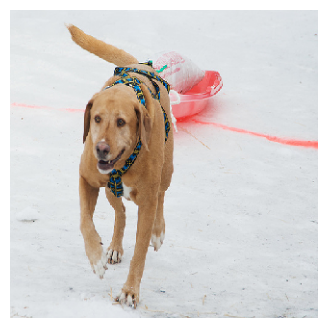


------------------------------------------------------------------------
Запрос: A white dog with a branch in his mouth and a black dog . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.09357701 



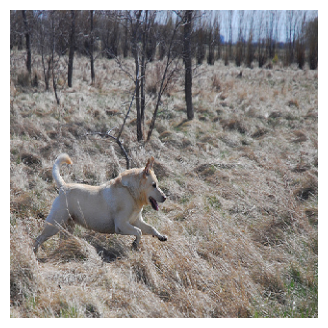


------------------------------------------------------------------------
Запрос: A man is doing a jump on a wakeboard in the water . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.45302755 



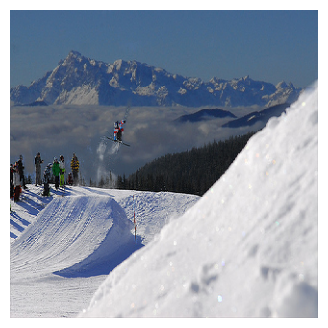


------------------------------------------------------------------------
Запрос: Two dogs play with each other outdoors . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.47052443 



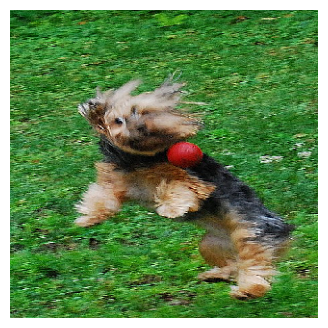


------------------------------------------------------------------------
Запрос: A white dog and a black dog in a field . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.13556334 



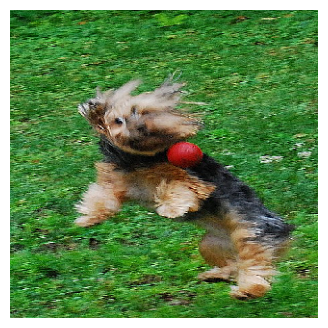


------------------------------------------------------------------------
Запрос: A three legged black and white dog running behind a brown dog with a red bandanna . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.0890442 



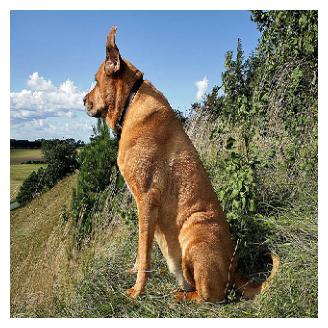


------------------------------------------------------------------------
Запрос: a baby is holding a controller to a video game above his head . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: a boxer punches a boxer in the face . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.5849121 



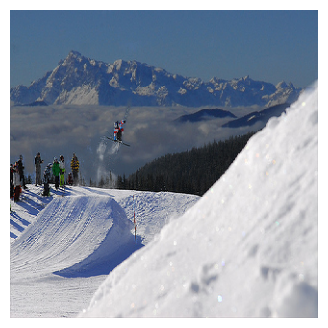


------------------------------------------------------------------------
Запрос: A group of people are ice skating in a big city . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.3171069 



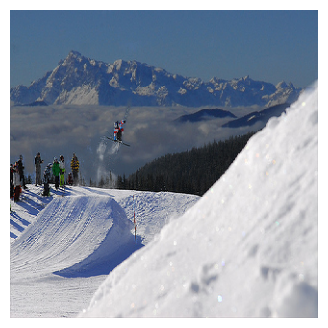


------------------------------------------------------------------------
Запрос: The woman lacrosse player in blue is about to catch the ball . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.115020305 



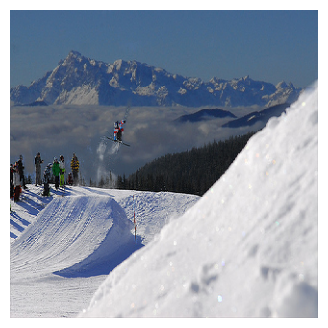

In [94]:
for _ in range(10):
    img_by_text( test_queries[random.randint(0, len(test_queries))] )


------------------------------------------------------------------------
Запрос: A caramel colored dog sits in front of trees looking forward . 



  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Gladky_S_Yu\.conda\envs\tensor_test\lib\site-packages\lightgbm\basic.py:1019: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')



Индекс соответствия по прогнозу модели: 0.09492074299338618 



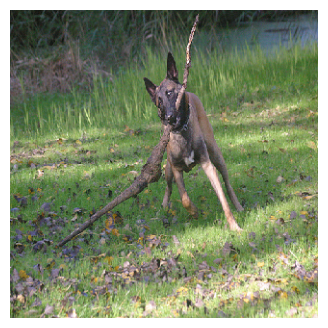


------------------------------------------------------------------------
Запрос: A girl is wearing a purple sash and matching skirt . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: Two boys in swimsuits standing under running water . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: A man and a woman are dressed as Groucho Marx with fake cigars . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.11211456371571232 



C:\Users\Gladky_S_Yu\.conda\envs\tensor_test\lib\site-packages\lightgbm\basic.py:1019: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


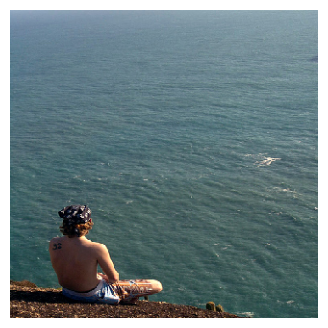


------------------------------------------------------------------------
Запрос: A group of women wearing red all rally together . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.1345555047510052 



C:\Users\Gladky_S_Yu\.conda\envs\tensor_test\lib\site-packages\lightgbm\basic.py:1019: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


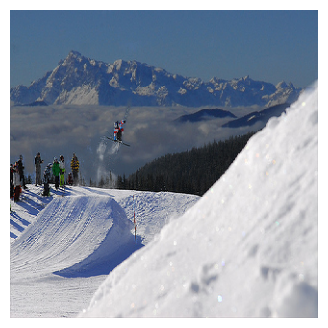


------------------------------------------------------------------------
Запрос: A black dog jumps up to a man 's uplifted hand . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.11945804338348136 



C:\Users\Gladky_S_Yu\.conda\envs\tensor_test\lib\site-packages\lightgbm\basic.py:1019: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


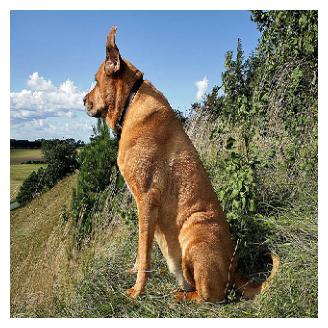


------------------------------------------------------------------------
Запрос: The boy jumps into the water off of a dock . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: The girl is blowing out the candles on the chocolate cake . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: A man in a black t-shirt is jumping something on his orange bike . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.13184417966716294 



C:\Users\Gladky_S_Yu\.conda\envs\tensor_test\lib\site-packages\lightgbm\basic.py:1019: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


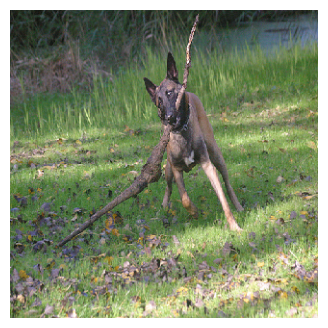


------------------------------------------------------------------------
Запрос: A man sits on a hill overlooking the ocean . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.08092858458462406 



C:\Users\Gladky_S_Yu\.conda\envs\tensor_test\lib\site-packages\lightgbm\basic.py:1019: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


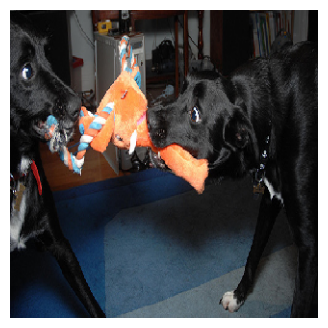

In [95]:
for _ in range(10):
    img_by_text( test_queries[random.randint(0, len(test_queries))], model=LGBModel )

**Вывод:** Полученные модели плохо попадают в заспрос. Для повышения качества подбора картинки необходимо увеличить количество описаний для каждой картинки, то есть необходимо увеличение количество исходных данных. 

- [x] Jupyter Notebook открыт
- [x] Весь код выполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Исследовательский анализ данных выполнен
- [x] Проверены экспертные оценки и краудсорсинговые оценки
- [x] Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x] Изображения векторизованы
- [x] Текстовые запросы векторизованы
- [x] Данные корректно разбиты на тренировочную и тестовую выборки
- [x] Предложена метрика качества работы модели
- [x] Предложена модель схожести изображений и текстового запроса
- [x] Модель обучена
- [x] По итогам обучения модели сделаны выводы
- [x] Проведено тестирование работы модели
- [x] По итогам тестирования визуально сравнили качество поиска